In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'))
TRAIN_PATH = ROOT_PATH + '/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

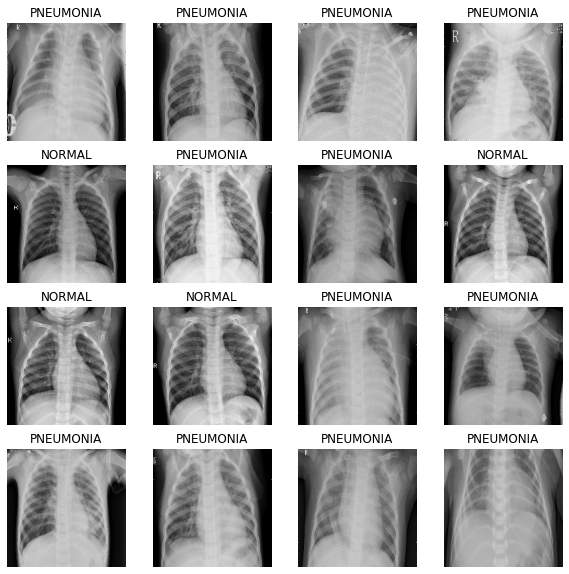

In [16]:

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


## ResNet18 모델

In [17]:
class BasicBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            out_channels, kernel_size=3, strides=stride,
            padding='same', use_bias=False
        )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(
            out_channels, kernel_size=3, strides=1,
            padding='same', use_bias=False
        )
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.downsample = downsample

    def call(self, x, training=False):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        if self.downsample is not None:
            identity = self.downsample(x, training=training)

        out += identity
        out = self.relu(out)
        return out

class ResNet(tf.keras.Model):
    def __init__(self, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            64, kernel_size=7, strides=2, padding='same', use_bias=False
        )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')

        self.in_channels = 64

        # ResNet-18: [2, 2, 2, 2]
        self.layer1 = self._make_layer(64,  layers[0], stride=1)
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        # 이진 분류
        self.fc = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = tf.keras.Sequential([
                tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=stride, use_bias=False),
                tf.keras.layers.BatchNormalization()
            ])

        layers = []
        layers.append(BasicBlock(out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels))

        return tf.keras.Sequential(layers)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.global_pool(x)
        x = self.fc(x)
        return x

def build_resnet18(input_shape=(180,180,3), num_classes=1):
    return ResNet(layers=[2, 2, 2, 2], num_classes=num_classes)

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_resnet18(input_shape=(180,180,3), num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
# 모델 요약
model.build(input_shape=(None, 180, 180, 3))
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9408      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 64)        148480    
_________________________________________________________________
sequential_2 (Sequential)    (None, 23, 23, 128)       526848    
_________________________________________________________________
sequential_4 (Sequential)    (None, 12, 12, 256)       2102

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 196ms/step - loss: 0.2986 - accuracy: 0.8977 - precision: 0.9653 - recall: 0.8948 - val_loss: 0.6755 - val_accuracy: 0.6923 - val_precision: 0.9588 - val_recall: 0.6078
Epoch 2/10
261/261 [==============================] - 52s 198ms/step - loss: 0.1770 - accuracy: 0.9315 - precision: 0.9764 - recall: 0.9305 - val_loss: 0.7327 - val_accuracy: 0.7548 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1139 - accuracy: 0.9586 - precision: 0.9867 - recall: 0.9572 - val_loss: 0.9723 - val_accuracy: 0.6558 - val_precision: 0.9880 - val_recall: 0.5386
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.0964 - accuracy: 0.9624 - precision: 0.9887 - recall: 0.9604 - val_loss: 0.4426 - val_accuracy: 0.8115 - val_precision: 0.9931 - val_recall: 0.7497
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1007 - accura

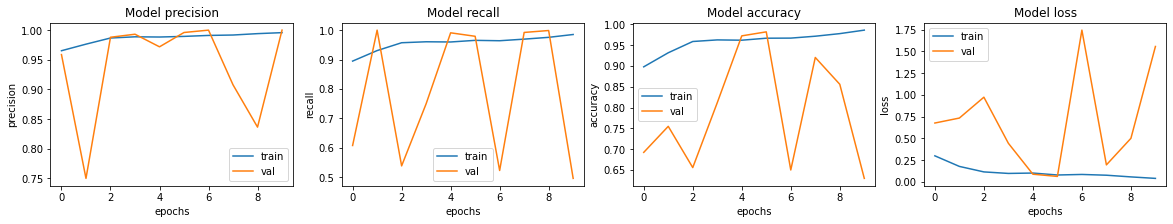

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.7524 - accuracy: 0.7772 - precision: 0.9254 - recall: 0.7000
Loss: 0.7523679733276367,
Accuracy: 0.7772436141967773,
Precision: 0.9254237413406372,
Recall: 0.699999988079071
